# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|      Name    |      Campus Email              | Personal Email        |
|--------------|--------------------------------|-----------------------|
|Itai Benyamin | itai.b@campus.technion.ac.il         |itai.benyamin@gmail.com|
|Idan Baruch   | idan-b@campus.technion.ac.il|idanb12200@gmail.com  |

## Introduction


In [7]:
import os
import shutil
import xmltodict
import numpy as np
import pandas as pd
import cv2
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchmetrics.detection import MeanAveragePrecision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "No device")

Is CUDA available: True
CUDA version: 12.4
PyTorch built with CUDA: True
Available devices: 1
Current device: 0


## Part 1 - Data Loading

In [8]:
kaggle_datapath = 'andrewmvd/pothole-detection'
if not os.path.exists('data'):
    #Load the data from kaggle
    data_path = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data_path, 'data')
else:
    print('Data already exists')

Data already exists


In [9]:
class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.img_files = sorted(os.listdir(img_dir), key=self._extract_index)
        self.ann_files = sorted(os.listdir(ann_dir), key=self._extract_index)
        self.transform = transform

    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')
    
    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
        
        return boxes
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
        
        return img, boxes, idx
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]  # List of images
    boxes = [item[1] for item in batch]  # List of bounding boxes
    indices = [item[2] for item in batch]  # List of indices
    return images, boxes, indices

In [10]:
# Paths to images and annotations
img_dir = "./data/images"
ann_dir = "./data/annotations"

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=seed)
train_set, val_set = train_test_split(train_set, test_size=0.125, random_state=seed)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")

Train set size: 465 - 69.92%
Validation set size: 67 - 10.08%
Test set size: 133 - 20.00%


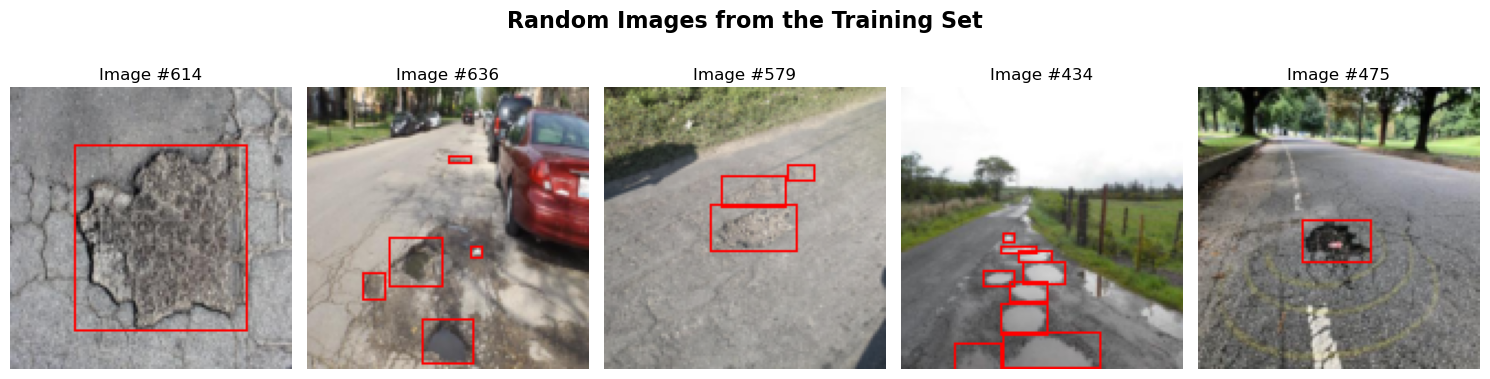

In [11]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, boxes, indices = next(iter(train_loader))

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, (img, bboxes, idx) in enumerate(zip(images, boxes, indices)):
    img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
    
    for box in bboxes:
        cv2.rectangle(img_np, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)
    
    axs[i].imshow(img_np)
    axs[i].axis("off")
    axs[i].set_title(f"Image #{idx}")

# Add a main title
plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.9)

plt.tight_layout()
plt.show()


## Part 2 - CNN

## Part 3 - ViT

## Part 4 - Smearing Noise

## Conclusions